# Corpus Modification

In [1]:
import json
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from nltk import word_tokenize
import numpy as np
import pandas as pd
import re
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from stop_words import get_stop_words
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder

from utils import add_epoch_division, alter_epoch_division, merge_corpus_poets, remove_noise_poet, text_cleaning

In [2]:
NOISELESS = True

In [3]:
if NOISELESS:
    corpus = text_cleaning(pd.read_csv("../corpora/german_poems_noiseless.csv"))
else:
    corpus = text_cleaning(pd.read_csv("../corpora/german_poems.csv"))

KeyboardInterrupt: 

#### add epoch division

In [16]:
with open("epochs.json") as f:
    epochs = json.loads(f.read())

epochs = epochs["amann"]
epoch_exceptions = ["Sturm_Drang"]
corpus = add_epoch_division(corpus, epochs, epoch_exceptions=epoch_exceptions)

#### merge poet

In [17]:
mod_corpus = merge_corpus_poets(corpus)

#### alter epoch division

In [18]:
with open("epochs_addition.json") as f:
    alternative_epochs = json.loads(f.read())

altered_corpus = alter_epoch_division(mod_corpus, alternative_epochs)
altered_corpus = altered_corpus[altered_corpus.epoch != ""]
altered_corpus = text_cleaning(altered_corpus)

#### shorten altered corpus

In [19]:
altered_corpus["poemlength"] = altered_corpus.poem.apply(lambda x: len(word_tokenize(x)))

In [20]:
altered_corpus = altered_corpus[altered_corpus.poemlength >= 1000]

In [21]:
altered_corpus.shape

(247, 6)

In [22]:
mod_corpus.shape

(313, 5)

#### saving corpus

In [23]:
altered_corpus.to_csv("../corpora/amann_poems.csv", index=False)

### plot original corpus distribution

In [24]:
corpus["poemlength"] = corpus.poem.apply(lambda x: len(word_tokenize(x)))

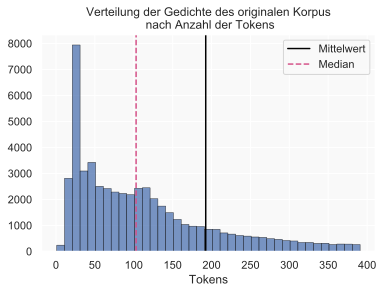

In [28]:
sns.distplot(corpus.poemlength, 
             kde=False, 
             rug=False, 
             bins=range(1, 400, 10), 
             hist_kws=dict(edgecolor="black", linewidth=0.5, alpha=0.75),
             axlabel="Tokens")
plt.axvline(corpus.poemlength.mean(), 0, 1, 
            linestyle="-",
            color="black",
            label="Mittelwert")
plt.axvline(corpus.poemlength.median(), 0, 1, 
            linestyle="--",
            color="#d45087",
            label="Median")
plt.legend()
sns.set(rc={'axes.facecolor':'#f9f9f9', 'figure.facecolor':'#ffffff'})
plt.title("Verteilung der Gedichte des originalen Korpus\n nach Anzahl der Tokens")
#plt.savefig("../results/figures/distributions/original_corpus_distribution.png", dpi=300)
plt.show()

### plot altered corpus distribution

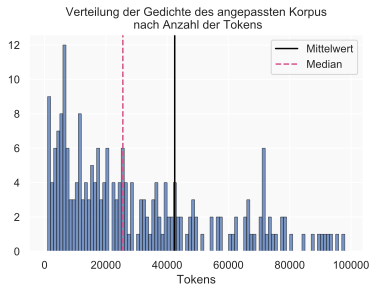

In [40]:
sns.distplot(altered_corpus.poemlength, 
             kde=False, 
             rug=False, 
             bins=range(1, 100000, 1000), 
             hist_kws=dict(edgecolor="black", linewidth=0.5, alpha=0.75),
             axlabel="Tokens")
plt.axvline(altered_corpus.poemlength.mean(), 0, 1, 
            linestyle="-",
            color="black",
            label="Mittelwert")
plt.axvline(altered_corpus.poemlength.median(), 0, 1, 
            linestyle="--",
            color="#d45087",
            label="Median")
plt.legend()
sns.set(rc={'axes.facecolor':'#f9f9f9', 'figure.facecolor':'#ffffff'})
plt.title("Verteilung der Gedichte des angepassten Korpus\n nach Anzahl der Tokens")
plt.savefig("../results/figures/distributions/altered_corpus_distribution.png", dpi=300)
plt.show()

## normlization of top words

In [1]:
from collections import Counter
import pandas as pd
import re
import json

In [2]:
with open("../results/amann_noise/kmeans_results_amann_noise_top100.json") as f:
    kmeans = json.load(f)

kmeans_scores = {}
kmeans_top_words = {}

for k,v in kmeans.items():
    kmeans_scores[k] = v["scores"]
    kmeans_top_words[k] = v["tw"]

In [3]:
topwords = pd.DataFrame.from_dict(kmeans_top_words, orient="index")
topwords.columns = ["cluster1", "cluster2"]
topwords["epoch"] = list(topwords.index)

In [4]:
frühbarock = []
for idx, row in topwords.iterrows():
    if "Hochbarock" in row["epoch"].split("/")[0]:
        frühbarock.append(row.cluster1)
frühbarock = [w for l in frühbarock for w in l]

In [6]:
corpus = pd.read_csv("../corpora/amann_poems_noiseless.csv")
corpus = corpus[corpus.epoch == "Frühbarock"]

In [8]:
from utils import replace_spelling

In [11]:
corpus["poem"] = corpus["poem"].apply(lambda x: replace_spelling(x))


In [12]:
corpus["poem"]

27     das liebste soll uns bloß das best in allem se...
28     wer wissen will was ein solldat, der zwar ein ...
52     des donners willder plitz schlug von sich manc...
63     qualis erit dicebat nuper sumo stylum dextra, ...
72     mein oft bestürmbtes schiff der grimmen winde ...
78     da/ wo der meisnerbach sich durch die thäler z...
101    leve peer nielßon latet my weten/ mög' gy so g...
112    ich weis/ ich weis/ wie viel an dẽ verglastẽ s...
133    es stritten ihrer zwey, ob schön, ob glauca he...
148    corydon der ging betrübet an der kalten cimber...
159    lasset uns den herren preisen, o ihr christen,...
178    wann morgen röth: die nacht ertödt, mit ihren ...
193    weil nu der luft ganz vngestim mit schnee und ...
202    echo zeige mier mein leben/ e. ja dier eben. w...
Name: poem, dtype: object

In [15]:
words = []
for idx, row in corpus.iterrows():
    if "jhr" in str(row.poem):
        words.append(row.poem[:1000])

In [19]:
for l in words:
    if "jhr" in l:
        print(l)
        break

Wer wissen wil was ein Soldat, Der zwar ein Hertz zu fechten hat, Nicht aber viel von Glück sol sagen, Für Noht und Elend müss' ertragen,Und wie der Herr zu seiner Zeit Die Seinen auß der Dienstbarkeit Vnd auß der schweren Arbeits-Ketten Mit Freuden wisse zu erretten,Der sehe Hans von Kalckstein an, Er wird in diesem werthen Mann Die Tapfferkeit sammt Noht und Grauen Gleich wie in einem Spiegel schauen.Du Weichling, welcher für den Feind Allein die reiche Beute meint, Und seine Mannheit darthut nimmer, Ohn wann er kömt zum Frauenzimmer.Geh, troll dich nur von hinnen weit; Ihr, die jhr liebt Gefahr und Streit, Vnd reicht dem Feind hin euer Leder, Kommt, schärfft mir beides Geist und Feder.Ich fühle nicht gemeinen Brand, Vnd wil durch eine weise Hand Der Nachwelt zu erkennen geben Deß werthen Mannes Glück und Leben.Er war von vierzehn Jahren kaum, Als er sich mit dem weiten Raum Der Arbeit außzog einzulassen, Vnd, was zur Tugend führt, zu fassen.Sein treues Hertz und reiner Mund Ward Joa